# Bring Your Own R Algorithm
_**Create a Docker container for training R algorithms and hosting R models**_

---

---

## Contents

1. [Background](#Background)
1. [Preparation](#Preparation)
1. [Code](#Code)
  1. [Fit](#Fit)
  1. [Serve](#Serve)
  1. [Dockerfile](#Dockerfile)
  1. [Publish](#Publish)
1. [Building The Container](#Building-The-Container)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
1. [Predict](#Predict)
1. [Review And Extensions](#Review-And-Extensions)

---
## Background

R is a popular open source statistical programming language, with a lengthy history in Data Science and Machine Learning.  The breadth of algorithms available as an R package is impressive, which fuels a growing community of users.  The R kernel can be installed into Amazon SageMaker Notebooks, and Docker containers which use R can be used to take advantage of Amazon SageMaker's flexible training and hosting functionality.  This notebook illustrates a simple use case for creating an R container and then using it to train and host a model.  We'll use R in both this notebook and the container - using the [reticulate](https://rstudio.github.io/reticulate/) package to connect with the AWS Python SDKs.

---
## Preparation

_This notebook was created and tested on an ml.t3.medium SageMaker Notebook Instance using the default R kernel._

> ⚠️ **Notes for SageMaker Studio Users:**
>
> - If you don't see an R kernel option available to run this notebook, you can use the step-by-step guide in the [documentation on custom Studio Images](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-byoi.html) with the [sample R image code](https://github.com/aws-samples/sagemaker-studio-custom-image-samples/tree/main/examples/r-image) to create and install one.
> - The [docker-build-push.sh](docker-build-push.sh) script used in this notebook uses the `docker` CLI, which is not available from SageMaker Studio notebooks at the time of writing. Instead of using this script, you can set up the [SageMaker Studio Docker Build CLI](https://github.com/aws-samples/sagemaker-studio-image-build-cli) and then use a command like: `sm-docker build . --repository sagemaker-rmars:latest`

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [18]:
# R Libraries:
library(IRdisplay)
library(repr)
library(reticulate)

# Local utilities:
source("util.R")

# Python Libraries via Reticulate:
boto3 <- import("boto3")
sagemaker <- import("sagemaker")

In [19]:
# Connect to AWS SDKs:
botosess <- boto3$Session()
smclient <- boto3$client("sagemaker")

# Set up role and bucket:
role <- sagemaker$get_execution_role()

prefix <- "byo/demo"
## change it to local or sagemaker
training_mode <- 'local'
cat('Notebook role:',role)

Notebook role: arn:aws:iam::613438712599:role/SageMakerFullAccess

In [20]:
# Change your  S3 bucket e.g 'rakesh-sagemaker-customer'
bucket <- 'rakesh-sagemaker-customer'

In [21]:
if("local" == training_mode){
    # Training mode sagemaker
    smsess <- sagemaker$LocalSession(botosess)
}else{
     # Training mode local
    smsess <- sagemaker$Session()
}
smsess

<sagemaker.local.local_session.LocalSession>

### Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because we'll be creating a new repository in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

![SageMakerStructure](image/SageMakerContainerStruct.png)
![SageMakerStructure](image/SageMakerPathExplain.png)




## Code

For this example, we'll need 3 supporting code files.

### Fit

[`mars.R`](mars.R) creates functions to fit and serve our model.  The algorithm we've chosen to use is [Multivariate Adaptive Regression Splines](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines).  This is a suitable example as it's a unique and powerful algorithm, but isn't as broadly used as Amazon SageMaker algorithms, and it isn't available in Python's scikit-learn library.  R's repository of packages is filled with algorithms that share these same criteria. 

_The top of the code is devoted to setup.  Bringing in the libraries we'll need and setting up the file paths as detailed in Amazon SageMaker documentation on bringing your own container._

```R
# Bring in library that contains multivariate adaptive regression splines (MARS)
library(mda)

# Bring in library that allows parsing of JSON training parameters
library(jsonlite)

# Bring in library for prediction server
library(plumber)


# Setup parameters
# Container directories
prefix <- '/opt/ml'
input_path <- paste(prefix, 'input/data', sep='/')
output_path <- paste(prefix, 'output', sep='/')
model_path <- paste(prefix, 'model', sep='/')
param_path <- paste(prefix, 'input/config/hyperparameters.json', sep='/')

# Channel holding training data
channel_name = 'train'
training_path <- paste(input_path, channel_name, sep='/')
```

_Next, we define a train function that actually fits the model to the data.  For the most part this is idiomatic R, with a bit of maneuvering up front to take in parameters from a JSON file, and at the end to output a success indicator._

```R

# Setup training function
train <- function() {
    # Read in hyperparameters
    training_params <- read_json(param_path)

    target <- training_params$target

    if (!is.null(training_params$degree)) {
        degree <- as.numeric(training_params$degree)
    } else {
        degree <- 2
    }

    # Bring in data
    training_files = list.files(path=training_path, full.names=TRUE)
    training_data = do.call(rbind, lapply(training_files, read.csv))
    
    # Convert to model matrix
    training_X <- model.matrix(~., training_data[, colnames(training_data) != target])

    # Save factor levels for scoring
    factor_levels <- lapply(
        training_data[, sapply(training_data, is.factor), drop=FALSE],
        function(x) { levels(x) }
    )
    
    # Run multivariate adaptive regression splines algorithm
    model <- mars(x=training_X, y=training_data[, target], degree=degree)
    
    # Generate outputs
    mars_model <- model[!(names(model) %in% c('x', 'residuals', 'fitted.values'))]
    attributes(mars_model)$class <- 'mars'
    save(mars_model, factor_levels, file=paste(model_path, 'mars_model.RData', sep='/'))
    print(summary(mars_model))

    write.csv(model$fitted.values, paste(output_path, 'data/fitted_values.csv', sep='/'), row.names=FALSE)
    write('success', file=paste(output_path, 'success', sep='/'))
}
```

_Then, we setup the serving function (which is really just a short wrapper around our plumber.R file that we'll discuss [next](#Serve)._

```R
# Setup scoring function
serve <- function() {
    app <- plumb(paste(prefix, 'plumber.R', sep='/'))
    app$run(host='0.0.0.0', port=8080)
}
```

_Finally, a bit of logic to determine if, based on the options passed when Amazon SageMaker Training or Hosting call this script, we are using the container to train an algorithm or host a model._

```R
# Run at start-up
args <- commandArgs()
if (any(grepl('train', args))) {
    train()
}
if (any(grepl('serve', args))) {
    serve()
}
```

### Serve
[`plumber.R`](plumber.R) uses the [plumber](https://www.rplumber.io/) package to create a lightweight HTTP server for processing requests in hosting.  Note the specific syntax, and see the plumber help docs for additional detail on more specialized use cases.

Per the Amazon SageMaker documentation, our service needs to accept post requests to ping and invocations.  plumber specifies this with custom comments, followed by functions that take specific arguments.

Here invocations does most of the work, ingesting our trained model, handling the HTTP request body, and producing a CSV output of predictions.

```R
# plumber.R

#' Ping to show server is there
#' @get /ping
function() {
    return('')
}


#' Parse input and return prediction from model
#' @param req The http request sent
#' @post /invocations
function(req) {
    # Setup locations
    prefix <- '/opt/ml'
    model_path <- paste(prefix, 'model', sep='/')

    # Bring in model file and factor levels
    load(paste(model_path, 'mars_model.RData', sep='/'))

    # Read in data
    conn <- textConnection(gsub('\\\\n', '\n', req$postBody))
    data <- read.csv(conn)
    close(conn)

    # Convert input to model matrix
    scoring_X <- model.matrix(~., data, xlev=factor_levels)

    # Return prediction
    return(paste(predict(mars_model, scoring_X, row.names=FALSE), collapse=','))
}
```

### Dockerfile

The [`Dockerfile`](Dockerfile) defines the container to run these scripts in, and keeps it minimal as smaller containers lead to faster spin-up times in training and endpoint creation.  It simply starts with Ubuntu; installs R, mda, and plumber libraries; then adds the `mars.R` and `plumber.R` scripts; and configures `mars.R` as the entry point script to run when the container is launched.

```Dockerfile
FROM ubuntu:20.04

# Don't prompt for tzdata on new versions of Ubuntu:
ARG DEBIAN_FRONTEND=noninteractive 

RUN apt-get -y update && apt-get install -y --no-install-recommends \
    wget \
    libcurl4-openssl-dev\
    libsodium-dev \
    r-base \
    r-base-dev \
    ca-certificates

RUN R -e "install.packages(c('mda', 'plumber'), repos='https://cloud.r-project.org')"

COPY mars.R /opt/ml/mars.R
COPY plumber.R /opt/ml/plumber.R

ENTRYPOINT ["/usr/bin/Rscript", "/opt/ml/mars.R", "--no-save"]
```

### Publish

For SageMaker to use this container image, it needs to be actually built and published to [Amazon ECR](https://aws.amazon.com/ecr/).

In [`docker-build-push.sh`](docker-build-push.sh), we provide a shell script to simplify running this process:

```bash
#!/bin/bash

# The name of our algorithm
algorithm_name=sagemaker-rmars

set -e # stop if anything fails

account=$(aws sts get-caller-identity --query Account --output text)
echo "AWS Account ID $account"

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}
echo "AWS Region $region"

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

echo "Target image URI $fullname"

# If the repository doesn't exist in ECR, create it.

echo "Checking for existing repository..."
set +e
aws ecr describe-repositories --repository-names "${algorithm_name}"
if [ $? -ne 0 ]
then
    set -e
    echo "Creating repository"
    aws ecr create-repository --repository-name "${algorithm_name}"
else
    set -e
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
docker build -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}
```

---
## Building The Container

Run this on terminal to see the output

First, we'll build the container image in Amazon ECR.

> ⏰ **Note: This command will take several minutes to run the first time, and will not show outputs until it's complete.**
>
> **If you'd like to see live updates as the command runs, consider running it from a terminal window intsead!**

In [ ]:
# Getting the output of terminal calls into the notebook is a little trickier than with Python,
# so we made a util.R function based on system2():
nbsystem2("./docker-build-push.sh")

---
## Data
For this illustrative example, we'll simply use `iris`.  This a classic, but small, dataset used to test supervised learning algorithms.  Typically the goal is to predict one of three flower species based on various measurements of the flowers' attributes.  Further detail can be found [here](https://en.wikipedia.org/wiki/Iris_flower_data_set).

Then let's copy the data to S3.

In [ ]:
train_file <- "traindata/iris.csv"
s3inputpath=smsess$upload_data(
    train_file,
    bucket=bucket,
    key_prefix=paste(prefix, "train", sep="/")
)
s3inputpath

_Note: Although we could, we'll avoid doing any preliminary transformations on the data, instead choosing to do those transformations inside the container.  This is not typically the best practice for model efficiency, but provides some benefits in terms of flexibility._

---
## Train

Now, let's setup the information needed to train a Multivariate Adaptive Regression Splines (MARS) model on iris data.  In this case, we'll predict `Sepal.Length` rather than the more typical classification of `Species` to show how factors might be included in a model and limit the case to regression.

First, we'll get our region and account information so that we can point to the ECR container we just created.

In [ ]:
region <- botosess$region_name
account <- boto3$client("sts")$get_caller_identity()$Account


- Specify the role to use
- Give the training job a name
- Point the algorithm to the container we created
- Specify training instance resources (in this case our algorithm is only single-threaded so stick to 1 instance)
- Point to the S3 location of our input data and the `train` channel expected by our algorithm
- Point to the S3 location for output
- Provide hyperparamters (keeping it simple)
- Maximum run time

Define an Amazon SageMaker Estimator, which can train any supplied algorithm that has been containerized with Docker. When creating the Estimator, use the following arguments:

    image_name - The container image to use for training
    role - The Amazon SageMaker service role
    train_instance_count - The number of Amazon EC2 instances to use for training
    train_instance_type - The type of Amazon EC2 instance to use for training
    train_volume_size - The size in GB of the Amazon Elastic Block Store (Amazon EBS) volume to use for storing input data during training
    train_max_run - The timeout in seconds for training
    input_mode - The input mode that the algorithm supports
    output_path - The Amazon S3 location for saving the training results (model artifacts and output files)
    output_kms_key - The AWS Key Management Service (AWS KMS) key for encrypting the training output
    base_job_name - The prefix for the name of the training job
    sagemaker_session - The Session object that manages interactions with Amazon SageMaker API


In [22]:
container=paste(account, ".dkr.ecr.", region, ".amazonaws.com/sagemaker-rmars:latest", sep="")
container

[1] "613438712599.dkr.ecr.us-east-1.amazonaws.com/sagemaker-rmars:latest"

In [23]:
s3_train_input <- sagemaker$session$s3_input(s3_data = s3inputpath,
                                     content_type = 'csv')
s3_output <- paste("s3:/", bucket, prefix, "output", sep="/")

In [24]:
if("local" == training_mode){
     instance_training_type =  'local'
 }else{
     instance_training_type =  'ml.m5.large'
}
instance_training_type

[1] "local"

In [25]:
estimator <- sagemaker$estimator$Estimator(image_uri= container,
                                           role = role,
                                           instance_count = 1L,
                                           instance_type =  instance_training_type,
                                           volume_size = 10L,
                                           max_run = 3600L,
                                           input_mode = 'File',
                                           output_path = s3_output,
                                           output_kms_key = NULL,
                                           base_job_name = NULL,
                                           sagemaker_session = smsess)

Now let's kick off our training job on Amazon SageMaker Training, using the parameters we just created. Because training is managed (AWS takes care of spinning up and spinning down the hardware), we don't have to wait for our job to finish to continue, but for this case, let's setup a waiter so we can monitor the status of our training.

In [26]:
tstart <- Sys.time()
estimator$set_hyperparameters(target="Sepal.Length",degree="2")
job_name <- paste("DEMO-r-byo",training_mode, strftime(Sys.time(), "%Y-%m-%d-%H-%M-%S"), sep="-")
input_data <- list('train' = s3_train_input)
estimator$fit(inputs = input_data,
              job_name = job_name)
tend <- Sys.time()
display(paste("Wall clock time elapsed:", repr(tend - tstart)))

[1] "Wall clock time elapsed: Time difference of 2.659932 secs"

In [27]:
estimator$model_data

[1] "s3://rakesh-sagemaker-customer/byo/demo/output/DEMO-r-byo-local-2021-04-05-18-13-28/model.tar.gz"

---
## Host

Hosting the model we just trained takes three steps in Amazon SageMaker. 

For our initial, low-volume testing in this notebook a single `ml.m5.large` should be easily enough.

In [28]:
if("local" == training_mode){
     instance_inference_type =  'local'
 }else{
     instance_inference_type =  'ml.m5.large'
}
instance_inference_type

[1] "local"

In [29]:
tstart <- Sys.time()
model_endpoint <- estimator$deploy(initial_instance_count = 1L,                                   
                                   instance_type = instance_inference_type)
tend <- Sys.time()
display(paste("Wall clock time elapsed:", repr(tend - tstart)))

[1] "Wall clock time elapsed: Time difference of 0.1850531 secs"

> ⏰ **Note:** This deployment can take a few minutes to complete

---
## Predict

Once our endpoint is successfully deployed, we can use it to generate real-time predictions.

_

In [30]:
model_endpoint$serializer <- sagemaker$predictor$csv_serializer

iris <- read.csv("traindata/iris.csv")

to_csv_str <- function(data) {
    # (Need to wrap this in a function or the `payload` var will be global and not reusable)
    payloadconn <- textConnection("payload", "w", local=TRUE)
    write.table(
        data,
        payloadconn,
        sep=",",
        row.names=FALSE
    )
    return(paste(payload, collapse="\n"))
}
test_sample = to_csv_str(iris[, !(names(iris) == "Sepal.Length")])
predictions <- model_endpoint$predict(test_sample)
predictions

b'["5.02506762494687,4.69519702476622,4.76812407406558,4.82019233557525,5.091041744983,5.46602767741009,4.95909350491074,5.01811469568364,4.62922290473009,4.82019233557525,5.21603705579203,5.07713588645654,4.69519702476622,4.51813345244751,5.23689584358171,5.67785589604494,5.22994291431848,5.02506762494687,5.40005355737397,5.28201117582816,5.13615707722945,5.21603705579203,4.85495698189139,5.07018295719332,5.25419945877525,4.81323940631203,5.07713588645654,5.08408881571977,4.95909350491074,4.94518764638428,4.87921352634816,5.01811469568364,5.47993353593655,5.48688646519978,4.82019233557525,4.70910288329267,4.96604643417397,5.091041744983,4.63617583399332,5.01811469568364,4.96604643417397,4.3722793538488,4.76812407406558,5.14311000649267,5.51809593891977,4.69519702476622,5.34103236660106,4.82714526483848,5.21603705579203,4.89311938487461,6.43530104455224,6.20536364075679,6.51437844936356,5.47968692528768,6.035214392773,6.04178683573265,6.41638928564037,5.16685826499774,6.19379128984332,

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“NAs introduced by coercion”


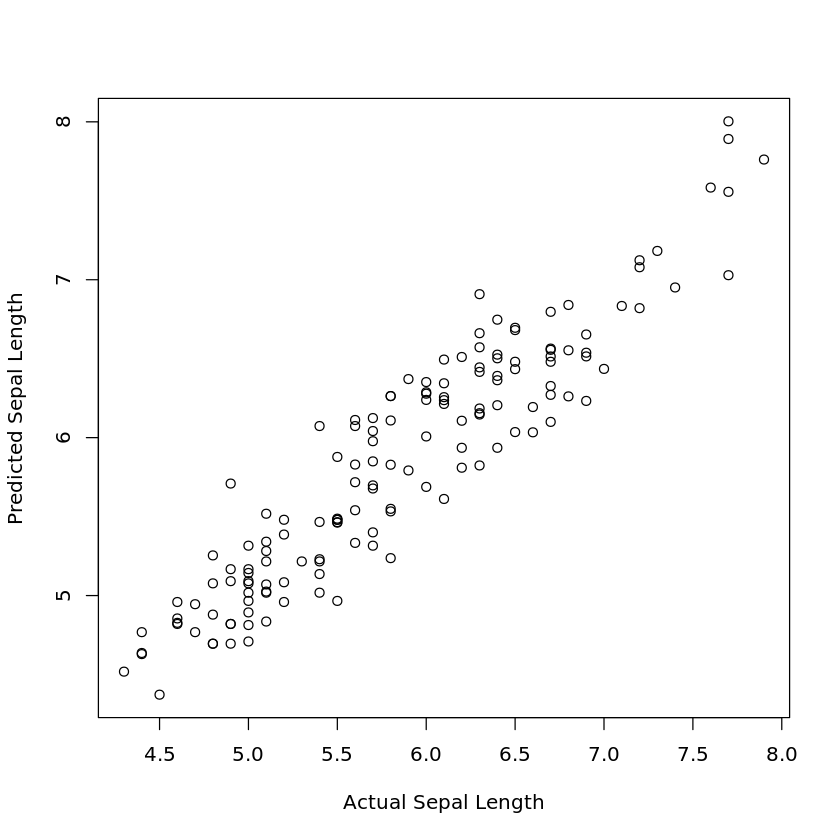

In [31]:
plot(
    iris[,"Sepal.Length"],
    as.numeric(unlist(strsplit(toString(predictions),","))),
    xlab="Actual Sepal Length",
    ylab="Predicted Sepal Length"
)

---
## (Optional) Clean-up

Unlike training jobs which start and stop compute infrastructure for defined jobs, SageMaker endpoints are deployed with the resources you configure and remain active until switched off.

When you're finished with this notebook, please run the cell below to delete the hosted endpoint you created and prevent ongoing charges.

In [32]:
smsess$delete_endpoint(model_endpoint$endpoint)